In [1]:
import numpy as np
import theano
import theano.tensor as T
from IPython import display

import matplotlib.pyplot as plt
import matplotlib
# %matplotlib inline
matplotlib.style.use('ggplot')

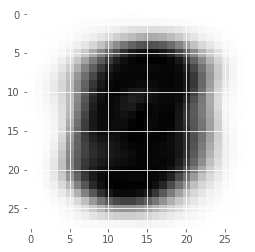

(24, 18)


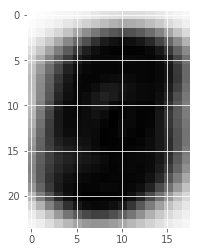

Training (50000, 1, 24, 18) (50000,)
Validation (10000, 1, 24, 18) (10000,)
Test (10000, 1, 24, 18) (10000,)


In [2]:
from mnist import load_dataset
X_train,y_train,X_val,y_val,X_test,y_test = load_dataset()
# X_test = X_test[:,0,...]
# X_train = X_train[:,0,...]
# X_val = X_val[:,0,...]

# X_train = X_train.reshape(X_train.shape[0],-1)
# X_val = X_val.reshape(X_val.shape[0],-1)
# X_test = X_test.reshape(X_test.shape[0],-1)

hot_points = np.std(X_train[:,0,...],axis=0)
plt.imshow(hot_points, cmap='Greys')
plt.show()
H = np.arange(2,26)
W = np.arange(5,23)
print(hot_points[H][:,W].shape)
plt.imshow(hot_points[H][:,W], cmap='Greys')
plt.show()

X_test = X_test[...,H,:][...,W]
X_train = X_train[...,H,:][...,W]
X_val = X_val[...,H,:][...,W]

print('Training', X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

### Save weights

In [3]:
all_weights_saved = []

def save_weights(all_weights):
    global all_weights_saved
    all_weights_saved = []
    for weight in all_weights:
        all_weights_saved.append(weight.get_value())

def restore_weights(all_weights):
    global all_weights_saved
    assert len(all_weights) == len(all_weights_saved)
    for weight, weight_saved in zip(all_weights, all_weights_saved):
        weight.set_value(weight_saved)

In [4]:
print('Training', X_train.shape, y_train.shape)
print('Validation', X_val.shape, y_val.shape)
print('Test', X_test.shape, y_test.shape)

Training (50000, 1, 24, 18) (50000,)
Validation (10000, 1, 24, 18) (10000,)
Test (10000, 1, 24, 18) (10000,)


### Building network

In [5]:
input_X = T.tensor4('X')
input_shape = [None]
input_shape.extend(X_train.shape[1:])
print(input_shape)
target_y = T.vector("target Y integer",dtype='int32')

[None, 1, 24, 18]


In [6]:
import lasagne
from lasagne.layers import *

layer = InputLayer(shape = input_shape,input_var=input_X)

layer = MaxPool2DLayer(layer, (2,2))
print(layer.input_shape, '->',layer.output_shape)

layer = Conv2DLayer(layer, num_filters=20, filter_size=(7,5), pad='same', nonlinearity=lasagne.nonlinearities.linear)
print(layer.input_shape, '->',layer.output_shape)


# layer = Conv2DLayer(layer, num_filters=20, filter_size=(7,5), pad='same', nonlinearity=lasagne.nonlinearities.linear)
# print(layer.input_shape, '->',layer.output_shape)


layer = MaxPool2DLayer(layer, (2,2))
print(layer.input_shape, '->',layer.output_shape)

layer = Conv2DLayer(layer, num_filters=10, filter_size=(3,3), pad='same', nonlinearity=lasagne.nonlinearities.linear)
print(layer.input_shape, '->',layer.output_shape)

# layer = Conv2DLayer(layer, num_filters=1, filter_size=(3,3))

layer = DropoutLayer(layer, p=0.6)
print(layer.input_shape, '->',layer.output_shape)

layer = DenseLayer(layer, num_units=100, nonlinearity=lasagne.nonlinearities.elu)
print(layer.input_shape, '->',layer.output_shape)

l_out = DenseLayer(layer,num_units = 10,nonlinearity=lasagne.nonlinearities.softmax)
print(l_out.input_shape, '->',l_out.output_shape)


(None, 1, 24, 18) -> (None, 1, 12, 9)
(None, 1, 12, 9) -> (None, 20, 12, 9)
(None, 20, 12, 9) -> (None, 20, 6, 4)
(None, 20, 6, 4) -> (None, 10, 6, 4)
(None, 10, 6, 4) -> (None, 10, 6, 4)
(None, 10, 6, 4) -> (None, 100)
(None, 100) -> (None, 10)


In [7]:
y_predicted = lasagne.layers.get_output(l_out)
y_test_predicted = lasagne.layers.get_output(l_out, deterministic=True)

all_weights = lasagne.layers.get_all_params(l_out)
print(all_weights)
loss = lasagne.objectives.categorical_crossentropy(y_predicted,target_y).mean()
accuracy = lasagne.objectives.categorical_accuracy(y_test_predicted,target_y).mean()
updates_sgd = lasagne.updates.adadelta(loss, all_weights,learning_rate=0.5,rho=0.8)
train_fun = theano.function([input_X,target_y],[loss,accuracy],updates= updates_sgd)
accuracy_fun = theano.function([input_X,target_y],accuracy)

[W, b, W, b, W, b, W, b]


In [8]:
def iterate_minibatches(inputs, targets, batchsize):
    assert len(inputs) == len(targets)
    indices = np.arange(len(inputs))
    np.random.shuffle(indices)
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        excerpt = indices[start_idx:start_idx + batchsize]
        yield inputs[excerpt], targets[excerpt]

## Load reserved weights

In [11]:
import pickle
with open('weights_1432687', 'rb') as input_stream:
    saved_params = pickle.load(input_stream)
    for saved_param, param in zip(saved_params, all_weights):
        param.set_value(saved_param)


# Training loop

In [ ]:
loss_history = []
val_acc_history = []
train_acc_history = []

In [ ]:
mas = 0.9
loss_history = loss_history[int(len(loss_history) * mas):]
val_acc_history = val_acc_history[int(len(val_acc_history) * mas):]
train_acc_history = train_acc_history[int(len(train_acc_history) * mas):]

In [ ]:
import time

num_epochs = 1000 #amount of passes through the data

batch_size = 300 #number of samples processed at each function call

for epoch in range(num_epochs):
    # In each epoch, we do a full pass over the training data:
    train_err = 0
    train_acc = 0
    train_batches = 0
    start_time = time.time()
    for batch in iterate_minibatches(X_train, y_train,batch_size):
        inputs, targets = batch
        train_err_batch, train_acc_batch= train_fun(inputs, targets)
        train_err += train_err_batch
        train_acc += train_acc_batch
        train_batches += 1

    # And a full pass over the validation data:
    val_acc = 0
    val_batches = 0
    for batch in iterate_minibatches(X_val, y_val, batch_size):
        inputs, targets = batch
        val_acc += accuracy_fun(inputs, targets)
        val_batches += 1

    
    loss = train_err / train_batches
    val_acc = val_acc / val_batches * 100
    train_acc = train_acc / train_batches * 100
    loss_history.append(loss)
    train_acc_history.append(train_acc)
    val_acc_history.append(val_acc)
    
#     print('Current loss: %f' % loss)   
    # Then we print the results for this epoch:
    if epoch % 1 == 0:
        display.clear_output(wait=True)

        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration):\t\t{:.6f}".format(loss))
        print("  train accuracy:\t\t{:.2f} %".format(train_acc))
        print("  validation accuracy:\t\t{:.2f} %".format(val_acc))
        plt.figure(figsize=(8, 6))
        plt.title("Training loss")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(loss_history, 'b')
        plt.figure(figsize=(8, 6))
        plt.title("Training accuracy")
        plt.xlabel("#iteration")
        plt.ylabel("loss")
        plt.plot(train_acc_history, 'r')
        plt.plot(val_acc_history, 'g')
        
        plt.show()

In [ ]:
save_weights(all_weights)

In [12]:
val_acc = 0
val_batches = 0
for batch in iterate_minibatches(X_val, y_val, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    val_acc += acc
    val_batches += 1
print("validation accuracy:\t\t{:.2f} %".format(
    val_acc / val_batches * 100))

validation accuracy:		98.84 %


In [14]:
test_acc = 0
test_batches = 0
for batch in iterate_minibatches(X_test, y_test, 500):
    inputs, targets = batch
    acc = accuracy_fun(inputs, targets)
    test_acc += acc
    test_batches += 1
print("Final results:")
print("  test accuracy:\t\t{:.2f} %".format(
    test_acc / test_batches * 100))

if test_acc / test_batches * 100 > 99:
    print ("Achievement unlocked: 80lvl Warlock!")
else:
    print ("We need more magic!")

Final results:
  test accuracy:		98.94 %
We need more magic!


In [13]:
restore_weights(all_weights)

AssertionError: 

In [ ]:
for i,j in zip([0,1,2,3,4,5],[0,1,2,3,4,5]):
    all_weights[i].set_value(all_weights_saved[j])

In [ ]:
all_weights[0].set_value(all_weights_saved[0])
all_weights[1].set_value(all_weights_saved[1])
all_weights[2].set_value(all_weights_saved[2])
all_weights[3].set_value(all_weights_saved[3])

In [ ]:
all_weights_saved_3 = all_weights_saved.copy

In [ ]:
all_weights[4].get_value(), all_weights_saved[3]

In [ ]:
import pickle

In [ ]:
with open('weights_1432687','wb') as output_stream:
    add_to_file = []
    for param in all_weights:
        add_to_file.append(param.get_value())
    pickle.dump(add_to_file, output_stream, -1)